In [18]:
# Installation and Setup
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import Dict, List, Any, Optional
import warnings
import gc
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Configuration
API_BASE_URL = "http://localhost:8000"
POLL_INTERVAL = 2  # seconds
MAX_WAIT = 300  # seconds

# Models to test
MODELS_TO_TEST = [
    "qwen3:latest",
    "gpt-oss:latest",
    "gemma3:latest",
    "deepseek-r1:8b"
]

# Prompting schema to use
SCHEMA_NAME = "translate"  # or "detailed", "simple"

print(f"🔧 Configuration:")
print(f"   API Base: {API_BASE_URL}")
print(f"   Models: {', '.join(MODELS_TO_TEST)}")
print(f"   Schema: {SCHEMA_NAME}")
print(f"\n✓ Setup complete!")

🔧 Configuration:
   API Base: http://localhost:8000
   Models: qwen3:latest, gpt-oss:latest, gemma3:latest, deepseek-r1:8b
   Schema: translate

✓ Setup complete!


In [19]:
# Load sentence transformer for semantic similarity analysis
print("Loading sentence transformer model for similarity comparison...")
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Sentence transformer loaded successfully")

Loading sentence transformer model for similarity comparison...
✓ Sentence transformer loaded successfully


In [20]:
# Test Texts - Various Chinese texts for comprehensive testing
TEST_TEXTS = [
    # 1. Forbidden City passage (cultural/historical)
    """北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫廷建筑的精华。北京故宫以三大殿为中心，占地面积72万平方米，建筑面积约15万平方米，有大小宫殿七十多座，房屋九千余间。是世界上现存规模最大、保存最为完整的木质结构古建筑之一。""",
    
    # 2. Technology and innovation (modern/technical)
    """人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的语音助手到自动驾驶汽车，人工智能已经渗透到日常生活的方方面面。机器学习算法能够分析海量数据，识别模式，并做出预测，这为医疗诊断、金融分析和个性化推荐等领域带来了革命性的变化。""",
    
    # 3. Environmental protection (social/policy)
    """环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生物多样性丧失威胁着人类的未来。各国政府和国际组织正在采取措施，推动可持续发展，包括发展清洁能源、减少温室气体排放和保护自然栖息地。""",
    
    # 4. Traditional Chinese philosophy (abstract/philosophical)
    """儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响。孔子提倡"己所不欲，勿施于人"的道德原则，主张通过教育和自我完善来实现社会和谐。这种以人为本的哲学理念至今仍然影响着东亚社会的价值观和行为准则。""",
    
    # 5. Modern urban life (conversational/contemporary)
    """现代城市生活节奏快、压力大，许多年轻人面临着工作和生活平衡的挑战。共享经济、外卖服务和移动支付等新兴科技改变了人们的消费习惯和生活方式。同时，城市规划者也在努力创造更宜居的环境，增加绿地空间，改善公共交通系统。"""
]

# Reference translations (from WMT or manual)
REFERENCE_TRANSLATIONS = [
    "The Forbidden City in Beijing is the imperial palace of the Ming and Qing dynasties in China, formerly known as the Forbidden City. It is the essence of ancient Chinese palace architecture. The Forbidden City centers on the three main halls, covering an area of 720,000 square meters with a building area of approximately 150,000 square meters. It has more than 70 palaces of various sizes and over 9,000 rooms. It is one of the largest and best-preserved wooden structures in the world.",
    
    "The development of artificial intelligence technology is profoundly changing our way of life. From voice assistants on smartphones to self-driving cars, AI has penetrated every aspect of daily life. Machine learning algorithms can analyze massive amounts of data, identify patterns, and make predictions, bringing revolutionary changes to fields such as medical diagnosis, financial analysis, and personalized recommendations.",
    
    "Environmental protection is one of the major challenges facing the world today. Climate change, air pollution, and biodiversity loss threaten humanity's future. Governments and international organizations are taking measures to promote sustainable development, including developing clean energy, reducing greenhouse gas emissions, and protecting natural habitats.",
    
    "Confucian thought emphasizes benevolence, propriety, and moral cultivation, and has had a profound impact on Chinese culture. Confucius advocated the moral principle of 'do not do to others what you do not want done to yourself,' and advocated achieving social harmony through education and self-improvement. This people-centered philosophical concept still influences the values and behavioral norms of East Asian societies today.",
    
    "Modern urban life is fast-paced and stressful, and many young people face challenges in balancing work and life. Emerging technologies such as the sharing economy, food delivery services, and mobile payments have changed people's consumption habits and lifestyles. At the same time, urban planners are working hard to create more livable environments, increase green spaces, and improve public transportation systems."
]

print(f"📝 Test corpus prepared:")
print(f"   Total texts: {len(TEST_TEXTS)}")
print(f"   Reference translations: {len(REFERENCE_TRANSLATIONS)}")
print(f"\nTest categories:")
print(f"   1. Cultural/Historical (Forbidden City)")
print(f"   2. Technology/Innovation (AI)")
print(f"   3. Social/Policy (Environment)")
print(f"   4. Abstract/Philosophical (Confucianism)")
print(f"   5. Contemporary/Conversational (Urban Life)")


📝 Test corpus prepared:
   Total texts: 5
   Reference translations: 5

Test categories:
   1. Cultural/Historical (Forbidden City)
   2. Technology/Innovation (AI)
   3. Social/Policy (Environment)
   4. Abstract/Philosophical (Confucianism)
   5. Contemporary/Conversational (Urban Life)


In [21]:
# Helper Functions

# Ollama configuration from .env
OLLAMA_API_BASE = "http://localhost:11000"  # Updated to match .env configuration

def check_api_health() -> bool:
    """Check if API is running and healthy."""
    try:
        response = requests.get(f"{API_BASE_URL}/health", timeout=5)
        response.raise_for_status()
        data = response.json()
        print(f"✓ API Status: {data.get('status')}")
        print(f"  Active Agent: {data.get('message')}")
        return data.get('status') == 'healthy'
    except Exception as e:
        print(f"✗ API health check failed: {e}")
        return False


def check_ollama_model(model_name: str) -> bool:
    """Check if a specific Ollama model is available."""
    try:
        response = requests.get(f"{OLLAMA_API_BASE}/api/tags", timeout=5)
        if response.status_code == 200:
            models = response.json().get('models', [])
            model_names = [m['name'] for m in models]
            return model_name in model_names
    except:
        pass
    return False


def unload_ollama_model(model_name: str) -> bool:
    """
    Unload a model from Ollama to free up VRAM.
    Uses a keep_alive=0 parameter to immediately unload the model.
    """
    try:
        print(f"   🧹 Unloading model: {model_name}...")
        response = requests.post(
            f"{OLLAMA_API_BASE}/api/generate",
            json={
                "model": model_name,
                "keep_alive": 0  # Immediately unload
            },
            timeout=10
        )
        if response.status_code == 200:
            print(f"   ✓ Model unloaded successfully")
            return True
        else:
            print(f"   ⚠️  Failed to unload model: HTTP {response.status_code}")
            return False
    except Exception as e:
        print(f"   ⚠️  Error unloading model: {e}")
        return False


def translate_with_model(text: str, model_name: str, schema_name: str = "translate") -> Optional[Dict[str, Any]]:
    """
    Translate text using specified model via async API endpoint.
    Returns the full result dictionary or None on failure.
    """
    try:
        # Submit async translation job
        print(f"   Submitting job for model: {model_name}...")
        response = requests.post(
            f"{API_BASE_URL}/translate/async",
            json={
                "text": text,
                "schema_name": schema_name,
                "model_override": model_name
            },
            timeout=10
        )
        response.raise_for_status()
        job_data = response.json()
        job_id = job_data.get('job_id')
        
        if not job_id:
            print(f"   ✗ No job_id returned")
            return None
        
        print(f"   Job ID: {job_id}")
        
        # Poll for completion
        start_time = time.time()
        while time.time() - start_time < MAX_WAIT:
            status_response = requests.get(
                f"{API_BASE_URL}/translate/status/{job_id}",
                timeout=10
            )
            status_response.raise_for_status()
            status_data = status_response.json()
            status = status_data.get('status')
            
            if status == 'completed':
                print(f"   ✓ Translation completed")
                return status_data.get('result', {})
            elif status == 'failed':
                error = status_data.get('error', 'Unknown error')
                print(f"   ✗ Translation failed: {error}")
                return None
            
            print(f"   Status: {status} - {status_data.get('progress', '')}")
            time.sleep(POLL_INTERVAL)
        
        print(f"   ✗ Translation timed out after {MAX_WAIT}s")
        return None
        
    except Exception as e:
        print(f"   ✗ Translation error: {e}")
        return None


def extract_translation_text(result: Dict[str, Any], model_key: str = "qwen") -> str:
    """
    Extract translated text from API result.
    Handles various response formats.
    """
    if not result:
        return ""
    
    translations = result.get('translations', {})
    model_data = translations.get(model_key, {})
    
    # Try different fields
    translation = model_data.get('translated_text') or \
                  model_data.get('translation') or \
                  model_data.get('text', '')
    
    return translation.strip() if translation else ""


def cleanup_memory():
    """Clean up memory between operations."""
    gc.collect()


# Verify API connectivity
print("\n🔍 Checking API health...")
if not check_api_health():
    print("\n⚠️  API is not accessible. Please ensure:")
    print("   1. API server is running: cd api && python main.py")
    print(f"   2. API is accessible at {API_BASE_URL}")
else:
    print("\n✓ API is ready!")

# Check model availability
print(f"\n🔍 Checking Ollama model availability (at {OLLAMA_API_BASE})...")
for model in MODELS_TO_TEST:
    available = check_ollama_model(model)
    status = "✓" if available else "✗"
    print(f"   {status} {model}")
    if not available:
        print(f"      To install: ollama pull {model}")



🔍 Checking API health...
✓ API Status: healthy
  Active Agent: API is running with QWEN agent

✓ API is ready!

🔍 Checking Ollama model availability (at http://localhost:11000)...
   ✓ qwen3:latest
   ✓ gpt-oss:latest
   ✓ gemma3:latest
   ✓ deepseek-r1:8b


In [25]:
# Main Translation Testing Loop

print("\n" + "="*80)
print("🚀 STARTING MODEL COMPARISON TEST")
print("="*80)

results = []
last_model_used = None  # Track the last model to unload it before switching

for text_idx, test_text in enumerate(TEST_TEXTS):
    print(f"\n{'='*80}")
    print(f"📝 Test Case {text_idx + 1}/{len(TEST_TEXTS)}")
    print(f"{'='*80}")
    print(f"Input: {test_text[:100]}...\n")
    
    reference_translation = REFERENCE_TRANSLATIONS[text_idx] if text_idx < len(REFERENCE_TRANSLATIONS) else ""
    
    # Dictionary to store translations from all models
    model_translations = {}
    model_results = {}
    
    # Test each model
    for model_name in MODELS_TO_TEST:
        print(f"\n🤖 Testing model: {model_name}")
        print("-" * 80)
        
        # Unload the previous model to free VRAM before loading the next one
        if last_model_used and last_model_used != model_name:
            print(f"   💾 Freeing VRAM by unloading previous model: {last_model_used}")
            unload_ollama_model(last_model_used)
            time.sleep(1)  # Give Ollama time to unload
        
        result = translate_with_model(test_text, model_name, SCHEMA_NAME)
        
        if result:
            # Extract translation text
            translation = extract_translation_text(result, model_key=model_name)
            model_translations[model_name] = translation
            model_results[model_name] = result
            print(f"   Translation: {translation[:150]}...")
            last_model_used = model_name  # Update last used model
        else:
            model_translations[model_name] = ""
            model_results[model_name] = {}
            print(f"   Failed to get translation")
        
        # Rate limiting and memory cleanup
        time.sleep(1)
        cleanup_memory()
    
    # Unload the last model used in this test case before moving to next
    if last_model_used:
        print(f"\n   💾 Unloading {last_model_used} before next test case...")
        unload_ollama_model(last_model_used)
        last_model_used = None
        time.sleep(1)
    
    # Calculate semantic similarities
    print(f"\n📊 Computing semantic similarities...")
    
    # Prepare embeddings
    valid_models = [m for m in MODELS_TO_TEST if model_translations.get(m)]
    
    if len(valid_models) < 2:
        print(f"   ⚠️  Not enough successful translations for comparison")
        continue
    
    # Compute embeddings for all translations + reference
    texts_to_embed = [model_translations[m] for m in valid_models]
    if reference_translation:
        texts_to_embed.append(reference_translation)
    
    try:
        embeddings = similarity_model.encode(texts_to_embed)
        
        # Compute pairwise similarities
        result_entry = {
            'text_idx': text_idx,
            'input_text': test_text,
            'reference_translation': reference_translation,
        }
        
        # Store individual model translations
        for model_name in MODELS_TO_TEST:
            result_entry[f'{model_name}_translation'] = model_translations.get(model_name, '')
            result_entry[f'{model_name}_result'] = model_results.get(model_name, {})
        
        # Compute all pairwise similarities between models
        for i, model1 in enumerate(valid_models):
            for j, model2 in enumerate(valid_models):
                if i < j:  # Only compute upper triangle
                    sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                    key = f"{model1}_vs_{model2}_similarity"
                    result_entry[key] = sim
            
            # Similarity to reference (if available)
            if reference_translation:
                ref_sim = cosine_similarity([embeddings[i]], [embeddings[-1]])[0][0]
                result_entry[f"{model1}_vs_reference_similarity"] = ref_sim
        
        results.append(result_entry)
        print(f"   ✓ Similarities computed successfully")
        
    except Exception as e:
        print(f"   ✗ Error computing similarities: {e}")
        continue
    
    cleanup_memory()

print(f"\n\n{'='*80}")
print(f"✅ TESTING COMPLETE")
print(f"{'='*80}")
print(f"Total test cases: {len(TEST_TEXTS)}")
print(f"Successful comparisons: {len(results)}")
print(f"Models tested: {', '.join(MODELS_TO_TEST)}")



🚀 STARTING MODEL COMPARISON TEST

📝 Test Case 1/5
Input: 北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫廷建筑的精华。北京故宫以三大殿为中心，占地面积72万平方米，建筑面积约15万平方米，有大小宫殿七十多座，房屋九千余间。是世界上现存规模最大、...


🤖 Testing model: qwen3:latest
--------------------------------------------------------------------------------
   Submitting job for model: qwen3:latest...
   Job ID: a6c7a373-8b79-46f8-bdaf-e9600f4bd6e2
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processing in progress...
   Status: processing - Processi

In [26]:
# Create Results DataFrame
if not results:
    print("❌ No results to analyze. Please check API connectivity and model availability.")
else:
    results_df = pd.DataFrame(results)
    print(f"\n📊 Results DataFrame created:")
    print(f"   Shape: {results_df.shape}")
    print(f"   Columns: {len(results_df.columns)}")
    
    # Display summary
    display(results_df.head())


📊 Results DataFrame created:
   Shape: (5, 21)
   Columns: 21


,text_idx,input_text,reference_translation,qwen3:latest_translation,qwen3:latest_result,gpt-oss:latest_translation,gpt-oss:latest_result,gemma3:latest_translation,gemma3:latest_result,deepseek-r1:8b_translation,...,qwen3:latest_vs_gpt-oss:latest_similarity,qwen3:latest_vs_gemma3:latest_similarity,qwen3:latest_vs_deepseek-r1:8b_similarity,qwen3:latest_vs_reference_similarity,gpt-oss:latest_vs_gemma3:latest_similarity,gpt-oss:latest_vs_deepseek-r1:8b_similarity,gpt-oss:latest_vs_reference_similarity,gemma3:latest_vs_deepseek-r1:8b_similarity,gemma3:latest_vs_reference_similarity,deepseek-r1:8b_vs_reference_similarity
0,0,北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫廷建筑的精华。北京故宫以三大殿为...,The Forbidden City in Beijing is the imperial ...,The Forbidden City in Beijing was the imperial...,{'input_text': '北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫...,The Forbidden City in Beijing was the imperial...,{'input_text': '北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫...,The Forbidden City in Beijing is the imperial ...,{'input_text': '北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫...,The Forbidden City in Beijing served as the im...,...,0.966476,0.901619,0.943396,0.922190,0.915432,0.946513,0.945902,0.918791,0.969609,0.925083
1,1,人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的语音助手到自动驾驶汽车，人工智能...,The development of artificial intelligence tec...,The development of artificial intelligence tec...,{'input_text': '人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的...,The development of artificial‑intelligence tec...,{'input_text': '人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的...,The development of artificial intelligence tec...,{'input_text': '人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的...,The development of artificial intelligence tec...,...,0.944406,0.963344,0.951790,0.975996,0.926654,0.932054,0.952872,0.968814,0.974578,0.962832
2,2,环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生物多样性丧失威胁着人类的未来。各...,Environmental protection is one of the major c...,Environmental protection is one of the major c...,{'input_text': '环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生...,Environmental protection is one of the major c...,{'input_text': '环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生...,环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生物多样性丧失威胁着人类的未来。各...,{'input_text': '环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生...,Environmental protection is one of the major c...,...,0.995818,0.209344,0.983511,0.997558,0.215218,0.985048,0.997790,0.221859,0.210919,0.986482
3,3,"儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响。孔子提倡""己所不欲，勿施于人""...","Confucian thought emphasizes benevolence, prop...","Confucian thought emphasizes benevolence, ritu...",{'input_text': '儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响...,"Confucian thought emphasizes benevolence, prop...",{'input_text': '儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响...,"儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响。孔子提倡""己所不欲，勿施于人""...",{'input_text': '儒家思想强调仁爱、礼仪和道德修养，对中国文化产生了深远的影响...,"Confucian thought emphasizes benevolence, etiq...",...,0.963250,0.391789,0.964255,0.981768,0.404993,0.951862,0.962163,0.396016,0.389426,0.975533
4,4,现代城市生活节奏快、压力大，许多年轻人面临着工作和生活平衡的挑战。共享经济、外卖服务和移动支...,"Modern urban life is fast-paced and stressful,...","Modern urban life is fast-paced and stressful,...",{'input_text': '现代城市生活节奏快、压力大，许多年轻人面临着工作和生活平衡的...,Modern urban life moves at a fast pace and car...,{'input_text': '现代城市生活节奏快、压力大，许多年轻人面临着工作和生活平衡的...,现代城市生活节奏快，压力大，许多年轻人面临着工作和生活平衡的挑战。共享经济、外卖服务和移动支...,{'input_text': '现代城市生活节奏快、压力大，许多年轻人面临着工作和生活平衡的...,"Urban life is fast-paced and stressful, with m...",...,0.950070,0.177117,0.979879,0.965897,0.207812,0.953477,0.970881,0.191054,0.206013,0.972639



📊 Creating Cross-Model Similarity Visualizations...


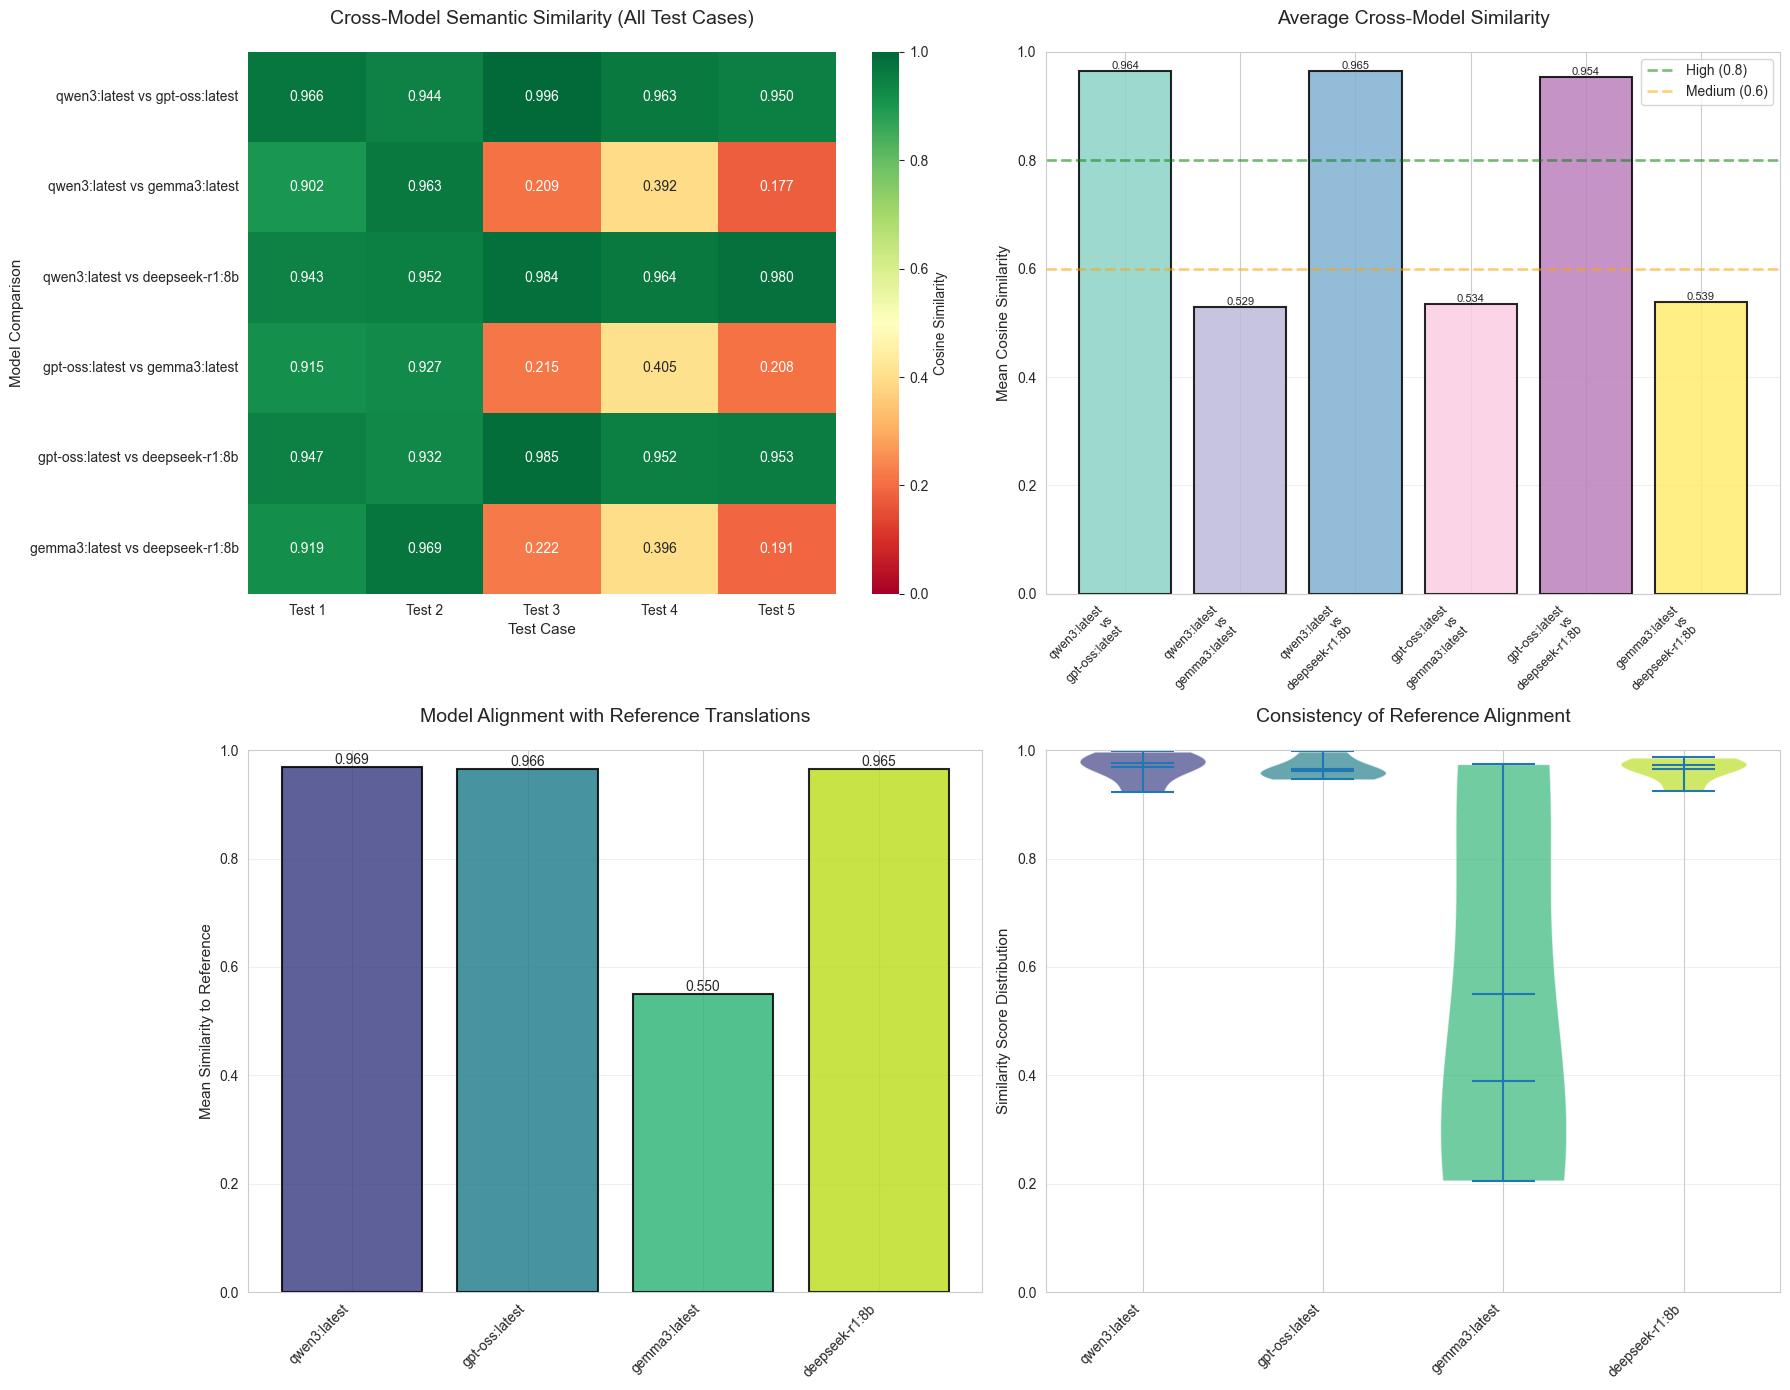

✓ Visualization saved as 'api_model_comparison_analysis.png'


In [27]:
# Visualization 1: Cross-Model Similarity Heatmap

if results:
    print("\n📊 Creating Cross-Model Similarity Visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Heatmap: Pairwise similarities across all test cases
    similarity_cols = [col for col in results_df.columns if '_vs_' in col and '_similarity' in col and 'reference' not in col]
    
    if similarity_cols:
        similarity_matrix = results_df[similarity_cols].T
        
        # Clean up column names for display
        clean_labels = [col.replace('_similarity', '').replace('_', ' ') for col in similarity_cols]
        
        sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0],
                    xticklabels=[f"Test {i+1}" for i in range(len(results_df))],
                    yticklabels=clean_labels,
                    vmin=0, vmax=1, cbar_kws={'label': 'Cosine Similarity'})
        axes[0, 0].set_title('Cross-Model Semantic Similarity (All Test Cases)', 
                            fontsize=14, fontweight='bold', pad=20)
        axes[0, 0].set_xlabel('Test Case', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Model Comparison', fontsize=11, fontweight='bold')
    
    # 2. Bar chart: Mean similarity scores
    if similarity_cols:
        mean_similarities = {col.replace('_similarity', '').replace('_', '\n'): 
                           results_df[col].mean() for col in similarity_cols}
        
        colors_palette = plt.cm.Set3(np.linspace(0, 1, len(mean_similarities)))
        bars = axes[0, 1].bar(range(len(mean_similarities)), list(mean_similarities.values()), 
                             color=colors_palette, edgecolor='black', linewidth=1.5, alpha=0.85)
        axes[0, 1].set_xticks(range(len(mean_similarities)))
        axes[0, 1].set_xticklabels(list(mean_similarities.keys()), rotation=45, ha='right', fontsize=9)
        axes[0, 1].set_ylabel('Mean Cosine Similarity', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('Average Cross-Model Similarity', fontsize=14, fontweight='bold', pad=20)
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='High (0.8)')
        axes[0, 1].axhline(y=0.6, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Medium (0.6)')
        axes[0, 1].legend(loc='upper right')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # 3. Reference alignment comparison
    ref_cols = [col for col in results_df.columns if 'vs_reference_similarity' in col]
    
    if ref_cols:
        ref_data = {col.replace('_vs_reference_similarity', ''): 
                   results_df[col].mean() for col in ref_cols}
        
        colors_ref = plt.cm.viridis(np.linspace(0.2, 0.9, len(ref_data)))
        bars_ref = axes[1, 0].bar(range(len(ref_data)), list(ref_data.values()),
                                  color=colors_ref, edgecolor='black', linewidth=1.5, alpha=0.85)
        axes[1, 0].set_xticks(range(len(ref_data)))
        axes[1, 0].set_xticklabels(list(ref_data.keys()), rotation=45, ha='right')
        axes[1, 0].set_ylabel('Mean Similarity to Reference', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('Model Alignment with Reference Translations', 
                            fontsize=14, fontweight='bold', pad=20)
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars_ref:
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Violin plot: Distribution of similarities
    if ref_cols:
        violin_data = [results_df[col].values for col in ref_cols]
        model_names = [col.replace('_vs_reference_similarity', '') for col in ref_cols]
        
        parts = axes[1, 1].violinplot(violin_data, positions=range(len(ref_cols)),
                                     showmeans=True, showmedians=True, widths=0.7)
        
        # Color the violin plots
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors_ref[i])
            pc.set_alpha(0.7)
        
        axes[1, 1].set_xticks(range(len(model_names)))
        axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
        axes[1, 1].set_ylabel('Similarity Score Distribution', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Consistency of Reference Alignment', 
                            fontsize=14, fontweight='bold', pad=20)
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('api_model_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualization saved as 'api_model_comparison_analysis.png'")
else:
    print("❌ No results available for visualization")

In [29]:
# Statistical Summary and Rankings

if results:
    print("\n" + "="*80)
    print("📈 STATISTICAL SUMMARY")
    print("="*80)
    
    # Cross-model similarity statistics
    if similarity_cols:
        print("\n🔄 Cross-Model Similarity Statistics:")
        print("-" * 80)
        
        cross_stats = []
        for col in similarity_cols:
            comparison = col.replace('_similarity', '').replace('_', ' vs ')
            cross_stats.append({
                'Comparison': comparison,
                'Mean': results_df[col].mean(),
                'Median': results_df[col].median(),
                'Std Dev': results_df[col].std(),
                'Min': results_df[col].min(),
                'Max': results_df[col].max()
            })
        
        cross_stats_df = pd.DataFrame(cross_stats)
        display(cross_stats_df)
    
    # Reference alignment statistics
    if ref_cols:
        print("\n🎯 Reference Alignment Statistics:")
        print("-" * 80)
        
        ref_stats = []
        for col in ref_cols:
            model = col.replace('_vs_reference_similarity', '')
            ref_stats.append({
                'Model': model,
                'Mean': results_df[col].mean(),
                'Median': results_df[col].median(),
                'Std Dev': results_df[col].std(),
                'Min': results_df[col].min(),
                'Max': results_df[col].max(),
                'Consistency Score': 1 - results_df[col].std()  # Lower std = higher consistency
            })
        
        ref_stats_df = pd.DataFrame(ref_stats)
        ref_stats_df = ref_stats_df.sort_values('Mean', ascending=False)
        display(ref_stats_df)
        
        # Rankings
        print("\n🏆 MODEL RANKINGS (by Reference Alignment):")
        print("-" * 80)
        for idx, row in ref_stats_df.iterrows():
            medal = ['🥇', '🥈', '🥉', '  '][min(idx, 3)]
            print(f"{medal} {row['Model']}: {row['Mean']:.4f} (consistency: {row['Consistency Score']:.4f})")
    
    # Per-test-case winners
    if ref_cols:
        print("\n📊 Per-Test-Case Winners:")
        print("-" * 80)
        
        for idx, row in results_df.iterrows():
            test_scores = {col.replace('_vs_reference_similarity', ''): row[col] for col in ref_cols}
            winner = max(test_scores, key=test_scores.get)
            winner_score = test_scores[winner]
            
            print(f"Test {idx + 1}: {winner} ({winner_score:.4f})")
            print(f"   Input: {row['input_text'][:80]}...")
            print(f"   All scores: {', '.join([f'{k}: {v:.3f}' for k, v in sorted(test_scores.items(), key=lambda x: x[1], reverse=True)])}")
            print()
else:
    print("❌ No results available for statistical analysis")


📈 STATISTICAL SUMMARY

🔄 Cross-Model Similarity Statistics:
--------------------------------------------------------------------------------


,Comparison,Mean,Median,Std Dev,Min,Max
0,qwen3:latest vs vs vs gpt-oss:latest,0.964004,0.963250,0.019982,0.944406,0.995818
1,qwen3:latest vs vs vs gemma3:latest,0.528643,0.391789,0.378262,0.177117,0.963344
2,qwen3:latest vs vs vs deepseek-r1:8b,0.964566,0.964255,0.017356,0.943396,0.983511
3,gpt-oss:latest vs vs vs gemma3:latest,0.534022,0.404993,0.362053,0.207812,0.926654
4,gpt-oss:latest vs vs vs deepseek-r1:8b,0.953791,0.951862,0.019406,0.932054,0.985048
5,gemma3:latest vs vs vs deepseek-r1:8b,0.539307,0.396016,0.377846,0.191054,0.968814



🎯 Reference Alignment Statistics:
--------------------------------------------------------------------------------


,Model,Mean,Median,Std Dev,Min,Max,Consistency Score
0,qwen3:latest,0.968682,0.975996,0.028407,0.922190,0.997558,0.971593
1,gpt-oss:latest,0.965922,0.962163,0.020158,0.945902,0.997790,0.979842
3,deepseek-r1:8b,0.964514,0.972639,0.023599,0.925083,0.986482,0.976401
2,gemma3:latest,0.550109,0.389426,0.392245,0.206013,0.974578,0.607755



🏆 MODEL RANKINGS (by Reference Alignment):
--------------------------------------------------------------------------------
🥇 qwen3:latest: 0.9687 (consistency: 0.9716)
🥈 gpt-oss:latest: 0.9659 (consistency: 0.9798)
   deepseek-r1:8b: 0.9645 (consistency: 0.9764)
🥉 gemma3:latest: 0.5501 (consistency: 0.6078)

📊 Per-Test-Case Winners:
--------------------------------------------------------------------------------
Test 1: gemma3:latest (0.9696)
   Input: 北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫廷建筑的精华。北京故宫以三大殿为中心，占地面积72万平方米，建筑面积约15万平方米，有大小宫殿七十多...
   All scores: gemma3:latest: 0.970, gpt-oss:latest: 0.946, deepseek-r1:8b: 0.925, qwen3:latest: 0.922

Test 2: qwen3:latest (0.9760)
   Input: 人工智能技术的发展正在深刻改变着我们的生活方式。从智能手机的语音助手到自动驾驶汽车，人工智能已经渗透到日常生活的方方面面。机器学习算法能够分析海量数据，识别模式...
   All scores: qwen3:latest: 0.976, gemma3:latest: 0.975, deepseek-r1:8b: 0.963, gpt-oss:latest: 0.953

Test 3: gpt-oss:latest (0.9978)
   Input: 环境保护是当今世界面临的重大挑战之一。气候变化、空气污染和生物多样性丧失威胁着人类的未来。各国政府和国际组织正在采取措施，推动可持续发展，包括发展清洁能源、减少...

In [30]:
# Detailed Translation Comparison Table

if results:
    print("\n" + "="*80)
    print("📋 DETAILED TRANSLATION COMPARISON")
    print("="*80)
    
    for idx, row in results_df.iterrows():
        print(f"\n{'='*80}")
        print(f"TEST CASE {idx + 1}")
        print(f"{'='*80}")
        
        print(f"\n📝 Input Text:")
        print(f"   {row['input_text']}")
        
        print(f"\n📚 Reference Translation:")
        print(f"   {row['reference_translation']}")
        
        print(f"\n🤖 Model Translations:")
        for model in MODELS_TO_TEST:
            trans_key = f"{model}_translation"
            if trans_key in row and row[trans_key]:
                print(f"\n   [{model}]")
                print(f"   {row[trans_key]}")
                
                # Show similarity score if available
                ref_sim_key = f"{model}_vs_reference_similarity"
                if ref_sim_key in row:
                    print(f"   Similarity to reference: {row[ref_sim_key]:.4f}")
        
        print()
else:
    print("❌ No results available for detailed comparison")


📋 DETAILED TRANSLATION COMPARISON

TEST CASE 1

📝 Input Text:
   北京故宫是中国明清两代的皇家宫殿，旧称为紫禁城，是中国古代宫廷建筑的精华。北京故宫以三大殿为中心，占地面积72万平方米，建筑面积约15万平方米，有大小宫殿七十多座，房屋九千余间。是世界上现存规模最大、保存最为完整的木质结构古建筑之一。

📚 Reference Translation:
   The Forbidden City in Beijing is the imperial palace of the Ming and Qing dynasties in China, formerly known as the Forbidden City. It is the essence of ancient Chinese palace architecture. The Forbidden City centers on the three main halls, covering an area of 720,000 square meters with a building area of approximately 150,000 square meters. It has more than 70 palaces of various sizes and over 9,000 rooms. It is one of the largest and best-preserved wooden structures in the world.

🤖 Model Translations:

   [qwen3:latest]
   The Forbidden City in Beijing was the imperial palace of the Ming and Qing dynasties, formerly known as the Purple Forbidden City, and represents the pinnacle of ancient Chinese palace architecture. Centered around the Three Grand Palaces, it spans 720,0

In [31]:
# Export Results

if results:
    print("\n💾 Exporting results...")
    
    # Export to CSV
    results_df.to_csv('api_model_comparison_results.csv', index=False)
    print("   ✓ CSV exported: api_model_comparison_results.csv")
    
    # Export to JSON (more detailed)
    results_df.to_json('api_model_comparison_results.json', orient='records', indent=2, force_ascii=False)
    print("   ✓ JSON exported: api_model_comparison_results.json")
    
    print("\n✅ All results exported successfully!")
else:
    print("❌ No results to export")


💾 Exporting results...
   ✓ CSV exported: api_model_comparison_results.csv
   ✓ JSON exported: api_model_comparison_results.json

✅ All results exported successfully!
